# Exploratory Data Analysis

This notebook explores a dataset of candidates. Their job title, where they are from, and how many 'connections' they have are the most pertentant features of this dataset at this point. The 'fit' feature will be discussed in the next phase of the project when we start ranking candidates on their relevancy to a given phrase that we are looking for in their job titles, such as 'aspiring human resources' or 'seeking human resources'.

The notebook is broken down into two main sections:
* Exploration of the features
* Techniques for representing words/sentences via vector embeddings

The second section looks at different ways to represent textual features:
* Tf-IDF (Term Frequency - Inverse Document Frequency)
* Word2Vec
* FastText
* GloVe
* BERT

Throughout the second part of the notebook you will see different plots of how I represented the textual embeddings in two dimensions. The last technique used, BERT, is not represented this way, so I returned the top 30 job titles from that model and compared it too the top 30 job titles of FastText to visualize the results in a more readable way.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.manifold import TSNE
import random
import sklearn
import spacy
import nltk
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('../Data/potential-talents - Aspiring human resources - seeking human resources.csv')
df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [3]:
df.shape

(104, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [5]:
######## helpfer function for countplots ########

def count_plot(df, feature_to_count=str, figsize=(10,20)):
    '''
    Parameters:
    df = pandas DataFrame
    feature_to_count = the feature in the DataFrame to count as a Str()
    figsize = size of graph that is rendered

    Return:
    A seaborn countplot of the feature_to_count parameter that is oriented on the x-axis
    '''

    plt.figure(figsize=figsize)
    sns.countplot(data=df, y=feature_to_count, orient='x')
    plt.xlabel(f"Count of {feature_to_count}'s")
    plt.ylabel(f"Unique {feature_to_count}'s in dataset")
    plt.title(f"Count of unique {feature_to_count}'s in dataset")
    plt.show()

There are 52 unique job titles in the dataset.


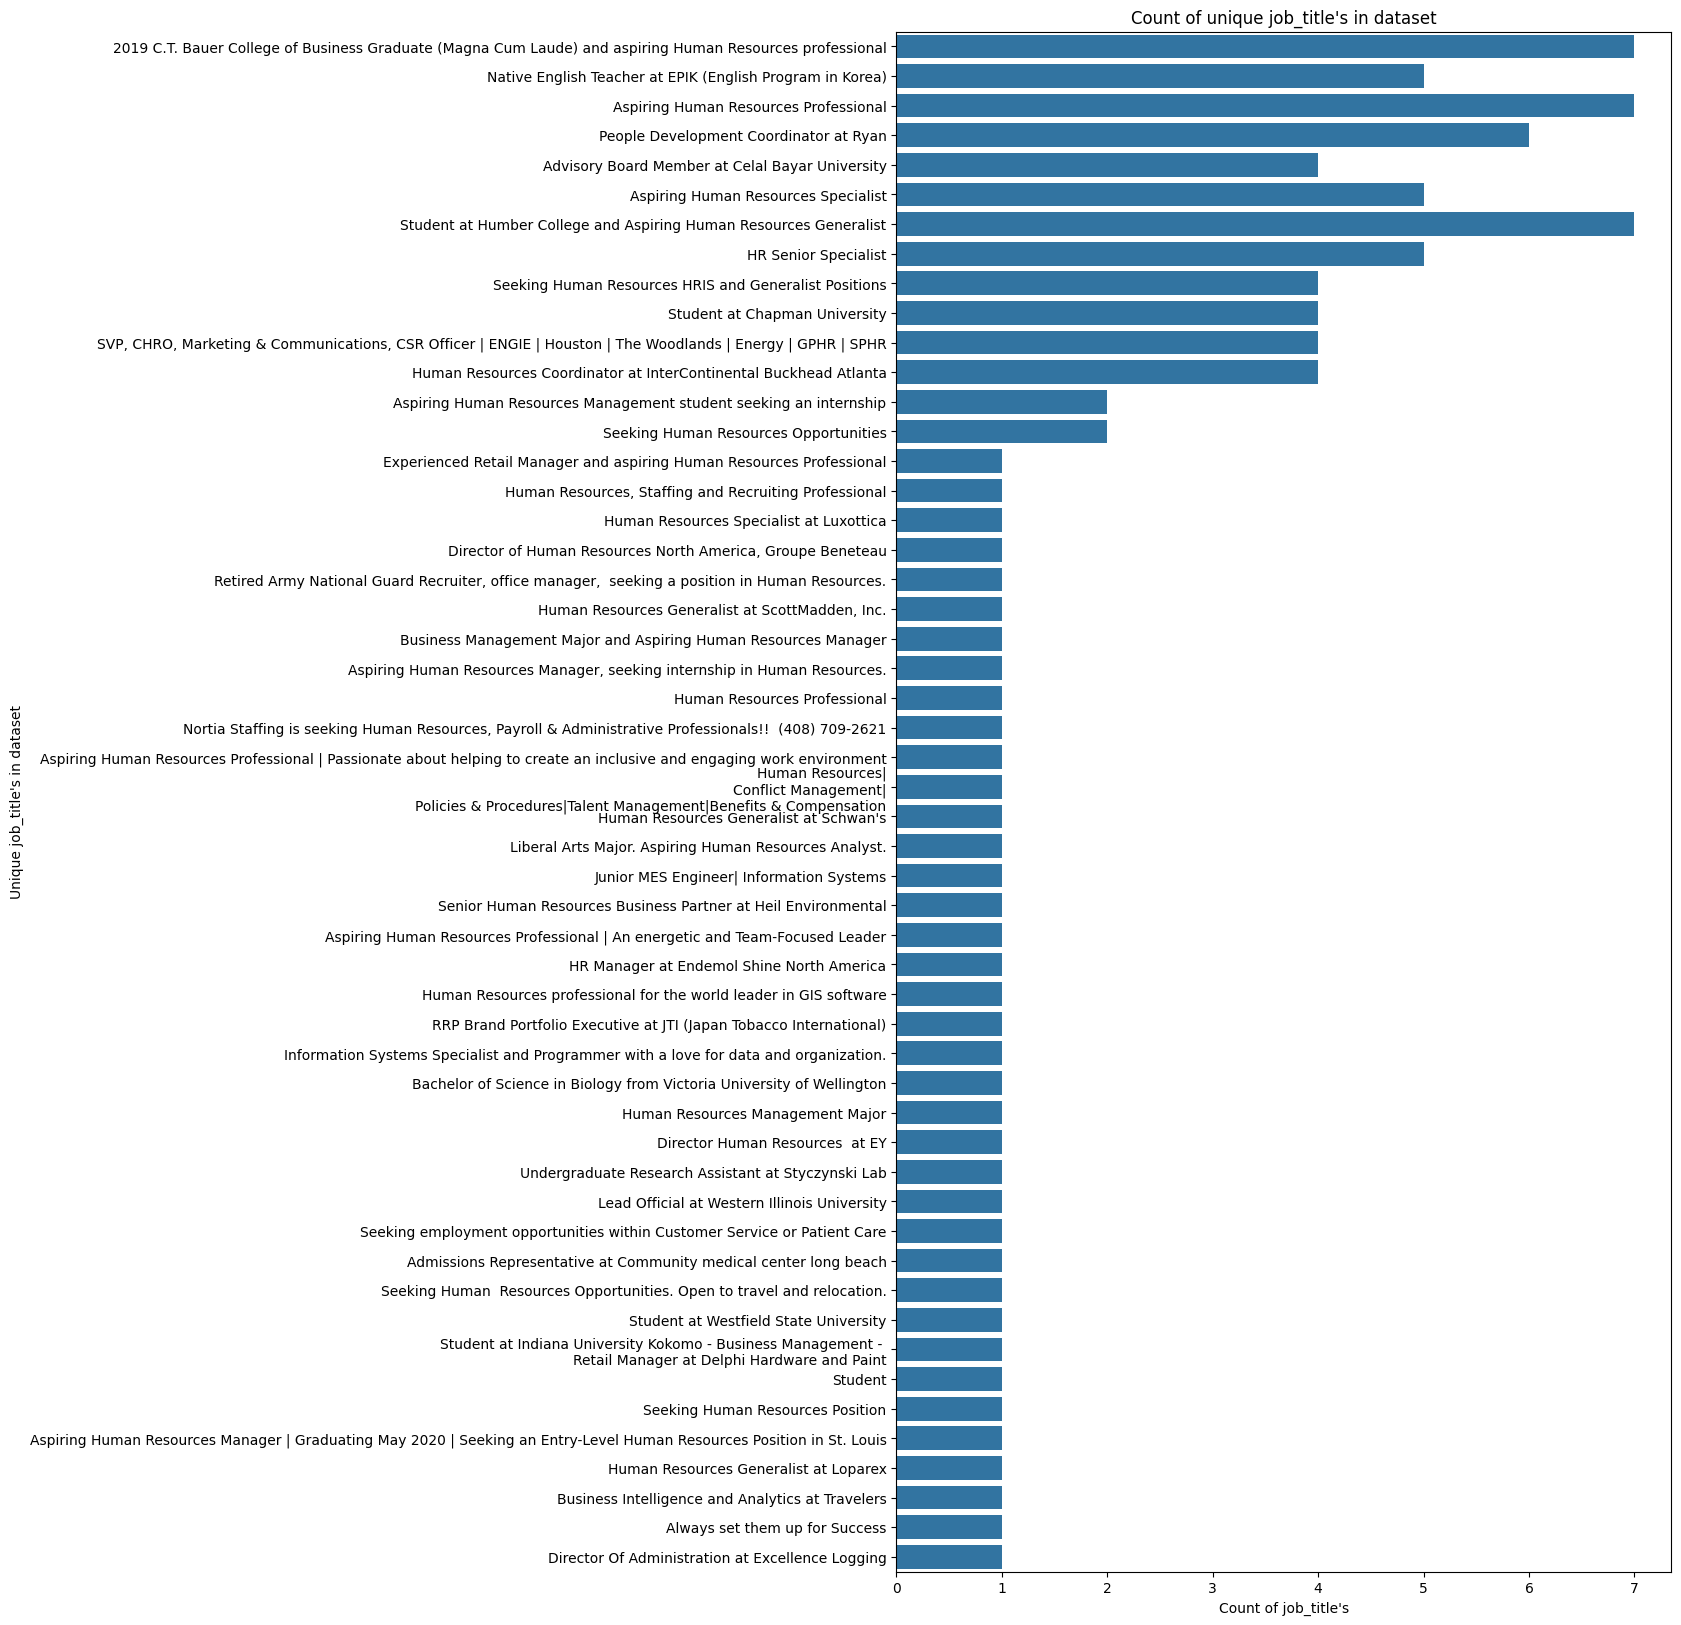

In [6]:
unique_job_titles = int(len(df['job_title'].unique()))

print(f"There are {unique_job_titles} unique job titles in the dataset.")

count_plot(df=df, feature_to_count='job_title')

There are 41 unique locations in the dataset.


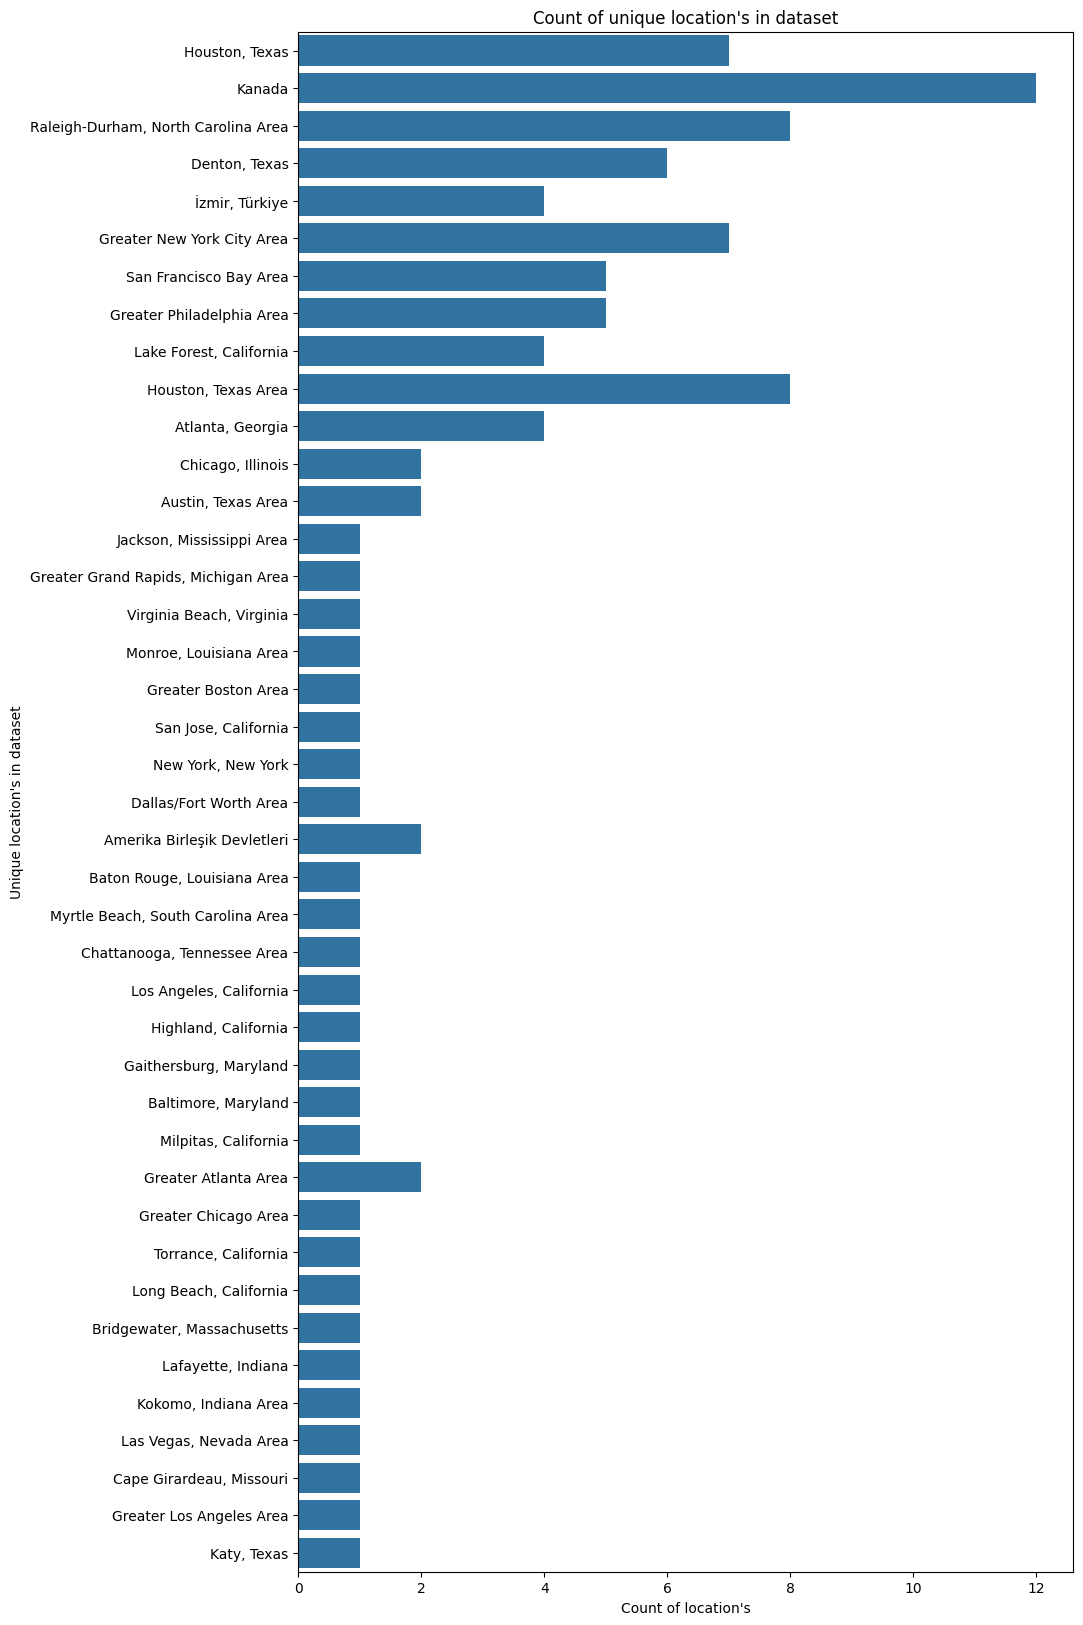

In [7]:
unique_locations = int(len(df['location'].unique()))
print(f"There are {unique_locations} unique locations in the dataset.")

count_plot(df=df, feature_to_count='location')

In [8]:
## strips the connections feature of the '+' character and sets the type of the values as int
df['connection'] = df['connection'].str.replace('+', '')
df['connection'] = df['connection'].astype(int)
df['connection'].dtype

connection = df['connection']

Number of unique connections: 33
Percentage of candidates with 500+ connections: 42.3%


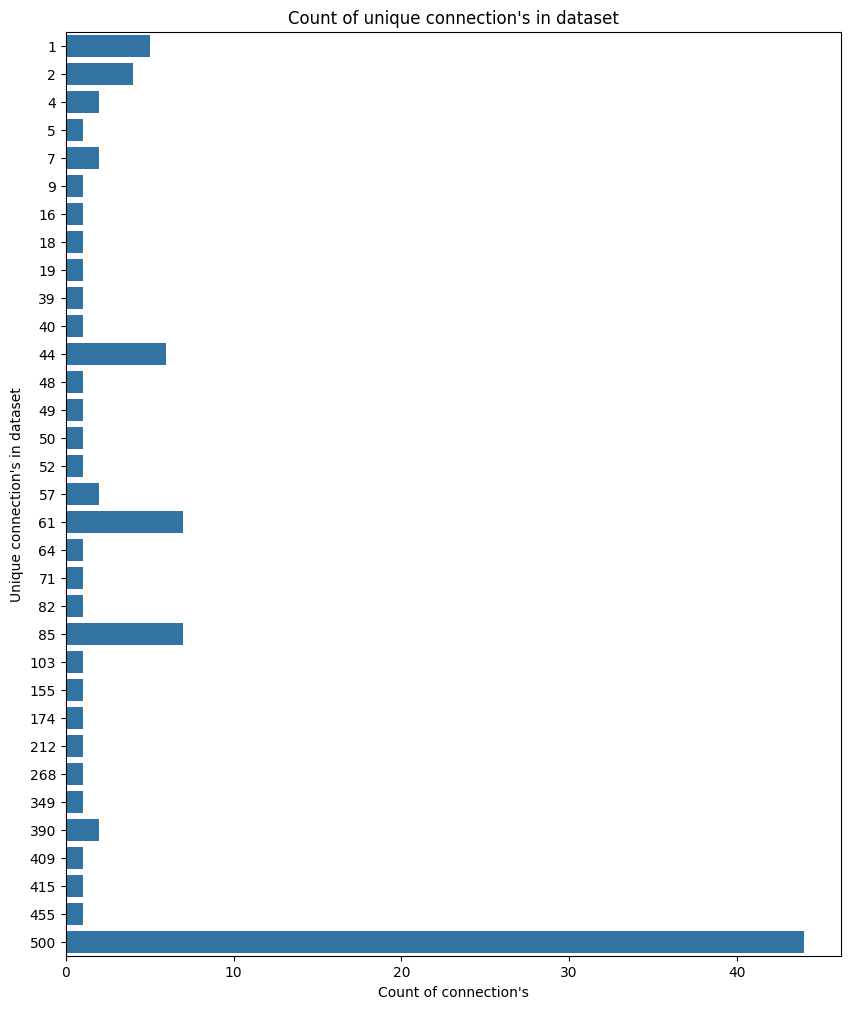

In [9]:
print('Number of unique connections:', int(len(df['connection'].unique())))

print(f"Percentage of candidates with 500+ connections: {round(len(df[df['connection'] == 500])/len(df), 3)*100}%")

count_plot(df=df, feature_to_count='connection', figsize=(10, 12))

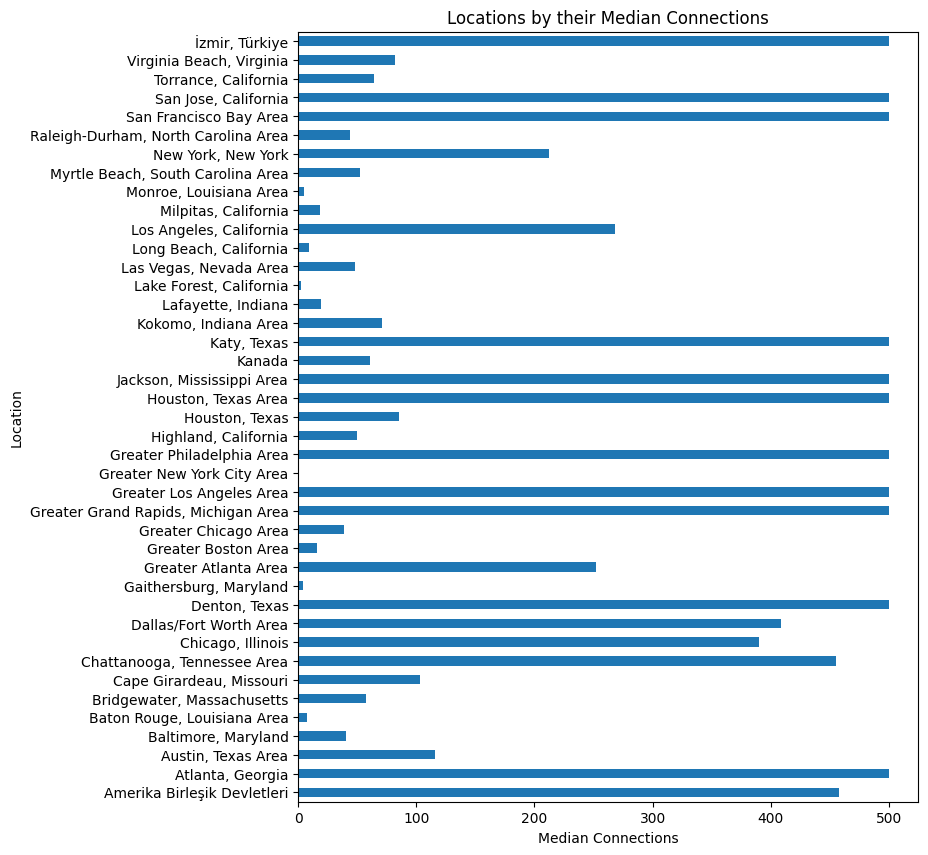

In [10]:
## groups the dataframe by the location feature and finds the median number of connections by that location
## The location names are not all uniform, but for the most part they convey what we need them for our problem
## in the future, 'Area' and 'Greater' should be eliminated but for now it is not a big deal

df.groupby('location')['connection'].median().plot.barh(x='connection', figsize=(8,10), ylabel='Location', xlabel='Median Connections', title='Locations by their Median Connections')
plt.show()

In [11]:
n = 5
print(f"{'-'*10}First {n} candidates' job titles {'-'*10}\n")
for title in df['job_title'][:n]:
    print(title)

----------First 5 candidates' job titles ----------

2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
Native English Teacher at EPIK (English Program in Korea)
Aspiring Human Resources Professional
People Development Coordinator at Ryan
Advisory Board Member at Celal Bayar University


In [12]:
import regex as re
## creates two features (type: float) that correspond to whether the job title has either 'aspiring human resources' or 'seeking human resources' in the title

df['aspiring_human_resources'] = df['job_title'].str.contains('aspiring human resources', flags=re.IGNORECASE).astype(float)
df['seeking_human_resources'] = df['job_title'].str.contains('seeking human resources', flags=re.IGNORECASE).astype(float)

In [13]:
df.head()

,id,job_title,location,connection,fit,aspiring_human_resources,seeking_human_resources
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,1.0,0.0
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500,NaN,0.0,0.0
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,1.0,0.0
3,4,People Development Coordinator at Ryan,"Denton, Texas",500,NaN,0.0,0.0
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500,NaN,0.0,0.0


## Candidates with 'Aspiring' in their job_title

These next two sections aim to look at how we could take a more in depth look at candidates based on their job titles via selecting for certain phrases such as what we will do when pre-ranking them in the next section.

In [14]:
df_asp = df[df['aspiring_human_resources']==1.0]
print(f"There are {df_asp.shape[0]} candidates with the key-words of 'aspiring human resources'.")

There are 35 candidates with the key-words of 'aspiring human resources'.


In [15]:
df_asp.head()

,id,job_title,location,connection,fit,aspiring_human_resources,seeking_human_resources
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,1.0,0.0
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,1.0,0.0
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,1.0,0.0
6,7,Student at Humber College and Aspiring Human R...,Kanada,61,NaN,1.0,0.0
8,9,Student at Humber College and Aspiring Human R...,Kanada,61,NaN,1.0,0.0


Of the candidates that have at least 'Aspiring' in their job title there are:
	11 unique locations
	12 unique connections


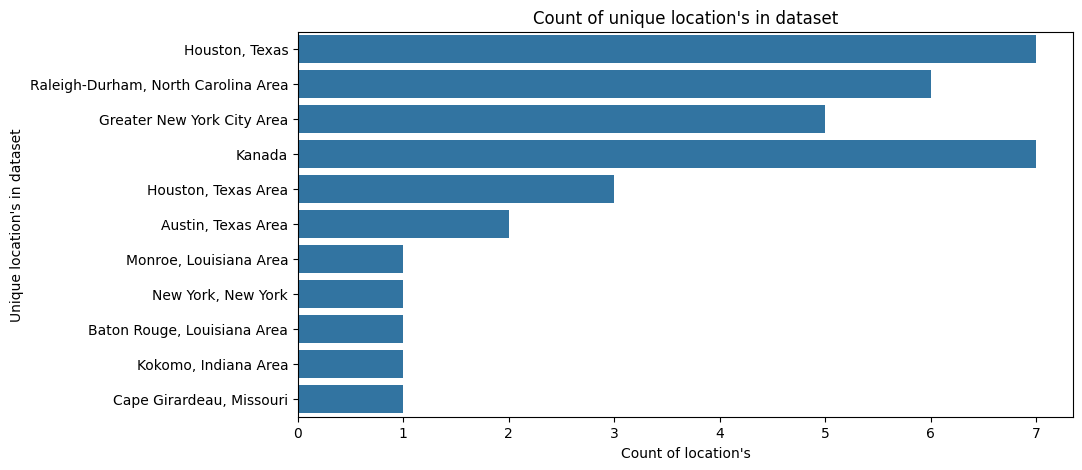

In [16]:
print(f"Of the candidates that have at least 'Aspiring' in their job title there are:\n\t{int(len(df_asp['location'].unique()))} unique locations\n\t{int(len(df_asp['connection'].unique()))} unique connections")

count_plot(df=df_asp, feature_to_count='location', figsize=(10,5))

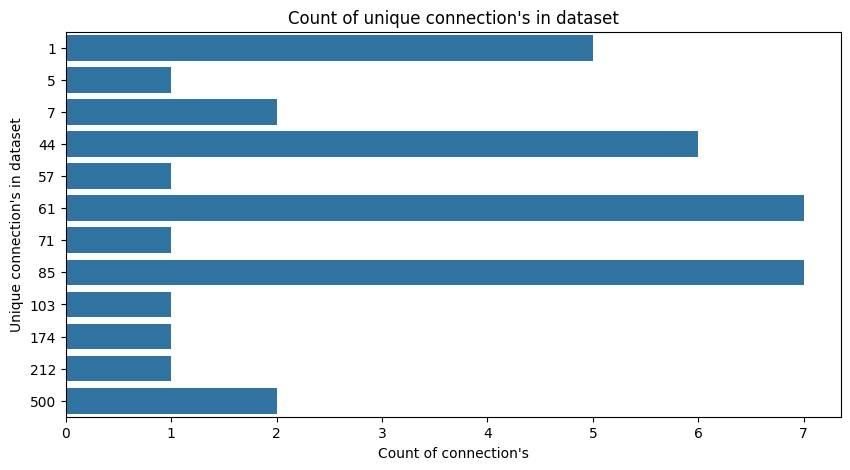

In [17]:
count_plot(df=df_asp, feature_to_count='connection', figsize=(10,5))

## Candidates with 'Seeking' in their job_title

In [18]:
df_seek = df[df['seeking_human_resources']==1.0]
print(f"There are {df_seek.shape[0]} candidates with the key-words 'seeking human resources'.")

There are 8 candidates with the key-words 'seeking human resources'.


In [19]:
df_seek.head()

,id,job_title,location,connection,fit,aspiring_human_resources,seeking_human_resources
9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500,NaN,0.0,1.0
27,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,NaN,0.0,1.0
29,30,Seeking Human Resources Opportunities,"Chicago, Illinois",390,NaN,0.0,1.0
39,40,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500,NaN,0.0,1.0
52,53,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500,NaN,0.0,1.0


Of the candidates that had at least 'Seeking' in their job title there are:
	4 unique locations
	3 unique connections


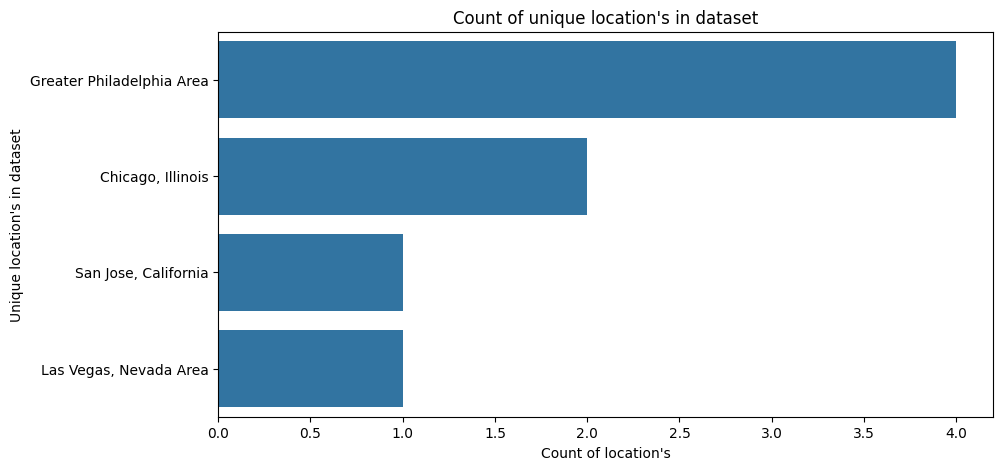

In [20]:
print(f"Of the candidates that had at least 'Seeking' in their job title there are:\n\t{int(len(df_seek['location'].unique()))} unique locations\n\t{int(len(df_seek['connection'].unique()))} unique connections")

count_plot(df=df_seek, feature_to_count='location', figsize=(10,5))

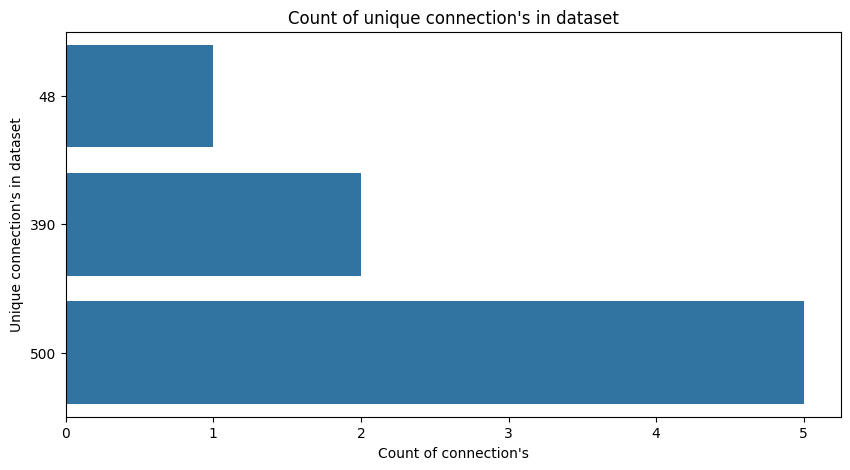

In [21]:
count_plot(df=df_seek, feature_to_count='connection', figsize=(10,5))

## Vectorization of job_title feature

This section looks at different techniques to vectorize the words in the job_title feature of the dataset.

Techniques used:
* Tf-IDF Vectorizer
* Word2Vec
* GloVe
* FastText
* BERT

### Tf-IDF Vectorization

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

count_vector = CountVectorizer()

transformed_vector = count_vector.fit_transform(df['job_title'])
# print(transformed_vector.toarray())
print('Shape of count vectorizer matrix:', transformed_vector.shape)
print(f'\t{transformed_vector.shape[0]} candidates: {transformed_vector.shape[1]} unique word characters')

Shape of count vectorizer matrix: (104, 200)
	104 candidates: 200 unique word characters


In [23]:
count_vector_df = pd.DataFrame(transformed_vector.toarray(), columns=count_vector.get_feature_names_out())
count_vector_df.head()

,2019,2020,2621,408,709,about,administration,administrative,admissions,advisory,...,up,victoria,wellington,western,westfield,with,within,woodlands,work,world
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [24]:
col_sums = [count_vector_df[name].sum() for name in count_vector.get_feature_names_out()] ## sums the amount of times each word is present in the job_title feature
col_sums = sorted(col_sums, reverse=True) ## sorts the sums by the highest words

column_word_counts = {word: count for word, count in zip(count_vector.get_feature_names_out(), col_sums)} ## create dictionary of the word and their respective counts
print(f"Total number of unique words that show up in 'job_title' feature: {transformed_vector.shape[1]}\n")
print(f"Words characters that show up more than 5x's in the dataset:")
for word, count in column_word_counts.items():
    if count > 5:
        print(f"\t{word}") ## prints the words that show up more than 5x's in the column_word_counts dictionary

Total number of unique words that show up in 'job_title' feature: 200

Words characters that show up more than 5x's in the dataset:
	2019
	2020
	2621
	408
	709
	about
	administration
	administrative
	admissions
	advisory
	always
	america
	an
	analyst
	analytics
	and
	army
	arts
	aspiring
	assistant
	at
	atlanta
	bachelor
	bauer
	bayar
	beach
	benefits
	beneteau
	biology
	board
	brand


In [25]:
## these 'stopwords' will be removed because 1.) they either appear at a high frequency in the job_titles or 2.) they are not 'interesting' enough for us to keep in the job title

stop_words = ['2019', '2020', '2621', '408', '709', 'a', 'an', 'at', 'and', 'the', 'of', 'with', 'within', 'without', 'about', 'always']

ngram_range=(1,3) ## you can change this value, but some posts have mentioned that a lower n-gram such as just a single word will yield not enough information whereas a high n-gram will be too memory intensive

vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3))

tfidf_matrix = vectorizer.fit_transform(df['job_title'])

In [26]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,administration,administration excellence,administration excellence logging,administrative,administrative professionals,admissions,admissions representative,admissions representative community,advisory,advisory board,...,westfield state,westfield state university,woodlands,woodlands energy,woodlands energy gphr,work,work environment,world,world leader,world leader in
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.261862,0.261862,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
job_title_query = vectorizer.transform(['Aspring Human Resources', 'Seeking human resources'])
cosine_sim = cosine_similarity(job_title_query, tfidf_df)
# print(cosine_sim)
print(f"Shape of matrix after cosine similarity transformation: {cosine_sim.shape}")

Shape of matrix after cosine similarity transformation: (2, 104)


In [28]:
######### cosine similarity of the 104 candidates to the phrase in question - first 2 columns are cosine similarity scores of the two titles. The last column is the candidates' id #########

__df = pd.DataFrame(cosine_sim.T, index=df['job_title'], columns=['aspring_cosine_score', 'seeking_cosine_score'])
__df['candidate_id'] = df.index+1
__df.head()

,aspring_cosine_score,seeking_cosine_score,candidate_id
job_title,,,
2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,0.152105,0.065461,1
Native English Teacher at EPIK (English Program in Korea),0.000000,0.000000,2
Aspiring Human Resources Professional,0.414043,0.178190,3
People Development Coordinator at Ryan,0.000000,0.000000,4
Advisory Board Member at Celal Bayar University,0.000000,0.000000,5


In [29]:
def get_recomendations(phrase=str, top_n=10):
    '''
    --- Parameters ---
    phrase: a Str that represents the type of candidates that should be looked at more closely
    top_n: an Int that represents the number of candidates to return to the user...default == 10

    --- Return ---
    A pandas Series object that has the candidates job_title as an index and their repsective index number from the original dataset as the value
    '''

    ## needs to be modified for apostrophes, slashes, etc...
    phrase = phrase.lower().strip()

    ## tranform the phrase that is looked for
    transformed_phrase = vectorizer.transform([phrase])

    ## calculates the cosine similarity score for the phrase in question to the corpus of text that is within the 'job_title' column of the dataset
    cosine_sim = cosine_similarity(transformed_phrase, tfidf_df) ## tfidf_df will be provided of the corpus of the job_titles

    ## creates a transposed DataFrame with 'job_title' as the index and the phrase cosine score and candidates index number as values
    transposed_df = pd.DataFrame(cosine_sim.T, index=df['job_title'], columns=["phrase_cosine_score"])
    transposed_df['candidate_index'] = df.index

    ## sort the DataFrame by 'phrase_cosine_score' in descending order
    sorted_cosine_scores_df = transposed_df.sort_values('phrase_cosine_score', ascending=False)
    
    # return sorted_cosine_scores_df[:top_n].candidate_index
    try:
        return sorted_cosine_scores_df[:top_n].candidate_index
    except:
        return 'top_n parameter needs to be an integer'

Below gives examples of using the function to look for candidates with a certain phrase within their job title  

In [30]:
get_recomendations('seeking human resources', top_n=5)

job_title
Seeking Human Resources Opportunities                    27
Seeking Human Resources Opportunities                    29
Seeking Human Resources Position                         98
Seeking Human Resources HRIS and Generalist Positions    52
Seeking Human Resources HRIS and Generalist Positions     9
Name: candidate_index, dtype: int64

In [31]:
get_recomendations('aspiring human resources')

job_title
Aspiring Human Resources Professional    96
Aspiring Human Resources Professional    57
Aspiring Human Resources Professional    16
Aspiring Human Resources Professional    32
Aspiring Human Resources Professional    20
Aspiring Human Resources Professional    45
Aspiring Human Resources Professional     2
Aspiring Human Resources Specialist       5
Aspiring Human Resources Specialist      59
Aspiring Human Resources Specialist      35
Name: candidate_index, dtype: int64

In [32]:
get_recomendations('Student at Humber College and Aspiring Human Resources Generalist', top_n=10)

job_title
Student at Humber College and Aspiring Human Resources Generalist     49
Student at Humber College and Aspiring Human Resources Generalist      8
Student at Humber College and Aspiring Human Resources Generalist     51
Student at Humber College and Aspiring Human Resources Generalist     38
Student at Humber College and Aspiring Human Resources Generalist     36
Student at Humber College and Aspiring Human Resources Generalist     24
Student at Humber College and Aspiring Human Resources Generalist      6
Human Resources Generalist at Schwan's                                77
Human Resources Generalist at Loparex                                100
Aspiring Human Resources Professional                                 96
Name: candidate_index, dtype: int64

In [33]:
get_recomendations('senior software developer', top_n=10)

job_title
HR Senior Specialist                                                                                                     50
HR Senior Specialist                                                                                                     25
HR Senior Specialist                                                                                                      7
HR Senior Specialist                                                                                                     60
HR Senior Specialist                                                                                                     37
Human Resources professional for the world leader in GIS software                                                        83
Senior Human Resources Business Partner at Heil Environmental                                                            80
2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional                  

### Word2Vec 
This section looks at utlizing the Word2Vec library from Gensim.

This section also looks at the differences between creating a model from scratch (in this case using the vocabulary from the job_title feature of the dataset) and using pre-trained models that are trained, in some cases, on billions of words.


In [34]:
import gensim
from gensim.models import Word2Vec, FastText, Phrases
from gensim.test.utils import datapath
from gensim import utils
import gensim.downloader as api
from gensim import corpora
from gensim.parsing.preprocessing import STOPWORDS

candidate_list=[]

### replaces all the non-numeric characters of the job_title feature with a space
df['job_title'] = df['job_title'].str.replace(".", "").replace(r'\'', "", regex=True)
df['job_title'] = df['job_title'].str.replace(r'[^a-zA-Z]+', ' ', regex=True)

## loops over each candidate in the dataset; lowering the case and stripping of the whitespace, splitting the job title into seperate word characters and then appending each new split list to the candidate_list.
for candidate in df['job_title']:
    candidate = candidate.lower().strip()
    candidate = candidate.split(" ")
    candidate_list.append(candidate)

candidate_list[:5]

[['ct',
  'bauer',
  'college',
  'of',
  'business',
  'graduate',
  'magna',
  'cum',
  'laude',
  'and',
  'aspiring',
  'human',
  'resources',
  'professional'],
 ['native',
  'english',
  'teacher',
  'at',
  'epik',
  'english',
  'program',
  'in',
  'korea'],
 ['aspiring', 'human', 'resources', 'professional'],
 ['people', 'development', 'coordinator', 'at', 'ryan'],
 ['advisory', 'board', 'member', 'at', 'celal', 'bayar', 'university']]

In [35]:
##### strips the stopwords out of candidate_list...using a predefined list of words that do not convey much information to the models #####

candidate_list_without_stopwords = []
for candidate in candidate_list:
    for word in candidate:
        candidate = [word for word in candidate if word not in STOPWORDS]
    candidate_list_without_stopwords.append(candidate)
candidate_list_without_stopwords[:5]

[['ct',
  'bauer',
  'college',
  'business',
  'graduate',
  'magna',
  'cum',
  'laude',
  'aspiring',
  'human',
  'resources',
  'professional'],
 ['native', 'english', 'teacher', 'epik', 'english', 'program', 'korea'],
 ['aspiring', 'human', 'resources', 'professional'],
 ['people', 'development', 'coordinator', 'ryan'],
 ['advisory', 'board', 'member', 'celal', 'bayar', 'university']]

In [36]:
len_ = [len(candidate) for candidate in candidate_list_without_stopwords]
print(f"The longest job title with stop words removed has {max(len_)} words in the title.")


candidate_list_without_stopwords_ = [' '.join(candidate) for candidate in candidate_list_without_stopwords]

print("\njob_title feature which has been lower-cased, stripped of unecessary whitespaces, punctuation, numbers, and stopwords.")
candidate_list_without_stopwords_[:5]

The longest job title with stop words removed has 13 words in the title.

job_title feature which has been lower-cased, stripped of unecessary whitespaces, punctuation, numbers, and stopwords.


['ct bauer college business graduate magna cum laude aspiring human resources professional',
 'native english teacher epik english program korea',
 'aspiring human resources professional',
 'people development coordinator ryan',
 'advisory board member celal bayar university']

In [37]:
## creates new pandas DataFrame for future use in other notebooks/files
# this new DataFrame has been modified from the original .csv file only in its job_title feature...stopwords and other unecessary characters have been omitted

## YOU CAN INGORE

# new_df = pd.DataFrame({'id': df['id'], 'job_title': c, 'connections': connection, 'location': df['location'], 'fit': df['fit']})
# new_df.to_csv('../Data/alterned_job_talents.csv')

In [38]:
######## for Word Cloud purposes #########

## YOU CAN INGORE

# candidate_list = [','.join(candidate) for candidate in candidate_list]
# cand_df = pd.DataFrame({'cand_list': candidate_list})
# cand_df.to_csv('../Misc_Files/job_title_total_words.csv')

In [39]:
SEED = random.randint(1000, 9999)

#### trains a Word2Vec model on the characters in the dataset...if the min_count is increased the words that appear less frequently will be excluded from the vocabulary.
word_2_vec_model = Word2Vec(candidate_list_without_stopwords, min_count=1, window=5, seed=SEED, epochs=100) 

word_indexes = word_2_vec_model.wv.key_to_index

#### dictionary of characters and their index
print("Unique word characters in 'job_title' feature:")
print(word_indexes)
print()
print(f"Model random state: {word_2_vec_model.seed}")
print(f"Model vector_size: {word_2_vec_model.vector_size}")
print(f"Length of vocab: {len(word_indexes)}")

Unique word characters in 'job_title' feature:
{'human': 0, 'resources': 1, 'aspiring': 2, 'professional': 3, 'student': 4, 'seeking': 5, 'college': 6, 'generalist': 7, 'specialist': 8, 'university': 9, 'business': 10, 'coordinator': 11, 'english': 12, 'manager': 13, 'humber': 14, 'management': 15, 'ct': 16, 'cum': 17, 'laude': 18, 'bauer': 19, 'graduate': 20, 'magna': 21, 'people': 22, 'development': 23, 'ryan': 24, 'senior': 25, 'hr': 26, 'korea': 27, 'program': 28, 'native': 29, 'teacher': 30, 'epik': 31, 'buckhead': 32, 'atlanta': 33, 'opportunities': 34, 'csr': 35, 'intercontinental': 36, 'sphr': 37, 'gphr': 38, 'energy': 39, 'woodlands': 40, 'houston': 41, 'officer': 42, 'engie': 43, 'communications': 44, 'hris': 45, 'advisory': 46, 'board': 47, 'celal': 48, 'bayar': 49, 'member': 50, 'positions': 51, 'chapman': 52, 'svp': 53, 'chro': 54, 'marketing': 55, 'internship': 56, 'major': 57, 'position': 58, 'director': 59, 'north': 60, 'systems': 61, 'leader': 62, 'america': 63, 'staff

In [40]:
def get_job_title_vectors(candidate_list, model):
    '''
    -- Parameters --
    candidate_list: a list of lists that represent individual word characters, i.e
        [['I', 'am'], ['She', 'is'], etc...]
    model: a Gensim model that has been trained and has word vectors that can be indexed
    dimensions: the number of dimensions of the word vectors. This depends on the dimensionality of the given model
        
    -- Returns --
    A list of vector representations of each job_title
    '''

    if type(model) == gensim.models.keyedvectors.KeyedVectors:
        job_title_vectors = []

        word_indexes = model.key_to_index

        for candidate in candidate_list:                          ## loops through split job titles
            title_vector = np.zeros(shape=(model.vector_size)) ## vector of n_dimensions (this case 100) of zeros
            for word in candidate:                                ## loops over each word in the candidate list
                if word in word_indexes.keys():                   ## makes sure the words are in the vocabulary
                    word_vector = model[word]                     ## selects word vector
                    title_vector += word_vector                   ## adds the word vector to title_vector

            title_vector_mean = (title_vector)/len(candidate)     ## average of each job title 
            job_title_vectors.append(title_vector_mean)           ## appends all averaged title vectors into a list

    else:
        job_title_vectors = []

        word_indexes = model.wv.key_to_index

        for candidate in candidate_list:                          ## loops through split job titles
            title_vector = np.zeros(shape=(model.vector_size)) ## vector of n_dimensions (this case 100) of zeros
            for word in candidate:                                ## loops over each word in the candidate list
                if word in word_indexes.keys():                   ## makes sure the words are in the vocabulary
                    word_vector = model.wv[word]                  ## selects word vector
                    title_vector += word_vector                   ## adds the word vector to title_vector

            title_vector_mean = (title_vector)/len(candidate)     ## average of each job title 
            job_title_vectors.append(title_vector_mean)           ## appends all averaged title vectors into a list

    return job_title_vectors


In [41]:
job_title_vectors = get_job_title_vectors(candidate_list_without_stopwords, word_2_vec_model)

In [42]:
def model_recommendation(model, job_title_vectors, phrase=str, start_num=int(0), end_num=int(10)):
    '''
    --- Parameters ---
    model: a trained Gensim Word2Vec or FastText model
    job_title_vectors: a list of vectors that represent each job_title in the dataset
    phrase: str() that is the job title you are looking for to compare to the candidates in the dataset
    start_num: int() that corresponds to the index that you wish to start at. 
        Default = 0. This will start at the top of the ordered list
    end_num: int() that corresponds to the index that you wish to stop at
        Default = 10. This will stop at the top 10 candidates in the ordered list

    --- Returns ---
    A pandas.Series object that shows the top n_results that match the phrase
    '''

    ## checks to see if the model passed into the function is a Word2Vec type
    if type(model) == gensim.models.word2vec.Word2Vec or type(model) == gensim.models.fasttext.FastText:
        
        ######### Phrase to compare to job_titles #########
        phrase_split = phrase.lower().split(" ") ## split the phrase into seperate words

        ## creates a numpy ndarray() with a shape of the model.vector_size. This is done so that each time through the subsequent for loop the word vector that is obtained gets braodcasted through the array. Thus making it easier to average in the end.
        phrase_vector = np.zeros(shape=(model.vector_size))       

        for word in phrase_split:
            if word in model.wv.key_to_index.keys():         ## checks to see that the words are in the vocabulary
                word_vector = model.wv[word]                 ## finds the word vector
                phrase_vector += word_vector                        

        phrase_vector_mean = (phrase_vector)/len(phrase_split)  ## average of the n-word phrase that is given...USED FOR COSINE SIMILARITY SCORE

    ## else it checks to see if the model is a KeyedVectors type. In other words, a pre-trained model.
    else:
        phrase_split = phrase.split(" ")

        phrase_vector = np.zeros(shape=(model.vector_size))

        for word in phrase_split:
            if word in model.key_to_index.keys():
                word_vector = model[word]
                phrase_vector += word_vector

        phrase_vector_mean = (phrase_vector)/len(phrase_split)
    
    cosine_scores = [cosine_similarity([phrase_vector_mean], [job]) for job in job_title_vectors]
    
    #### Creates pandas.DataFrame that has job_title, job index, and cosine score for sorting
    _df = pd.DataFrame({'cosine_scores': cosine_scores}, index=df['job_title'])
    _df['candidate_index'] = df.index
    sorted_cosine_scores_df = _df.sort_values(by='cosine_scores', ascending=False)
    
    try:
        return sorted_cosine_scores_df[start_num:end_num].candidate_index
    except:
        return "'top_n' and 'start_num' parameters need to be integers"


In [43]:
def plot_vector_representation(model, n=25):
    if type(model) == gensim.models.word2vec.Word2Vec or type(model) == gensim.models.fasttext.FastText:
        word_vectors = np.asarray(model.wv.vectors)
        labels = np.asarray(model.wv.index_to_key)
        
    else: ## for pre-trained models
        word_vectors = np.asarray(model.vectors)
        labels = np.asarray(model.index_to_key)

    ###### use t-SNE to look at how close words appear to each other in a 2-dimensional space
    tsne = TSNE(n_components=2, random_state=SEED)
    tranformed_vectors = tsne.fit_transform(word_vectors)

    x_vals = [w[0] for w in tranformed_vectors]
    y_vals = [w[1] for w in tranformed_vectors]

    plt.figure(figsize=(8,8))
    plt.scatter(x_vals, y_vals)
    plt.title('Word Vector Representation using t-SNE')

    indices = list(range(len(labels)))
    
    selected_indices = random.sample(indices, n)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))
    plt.show()

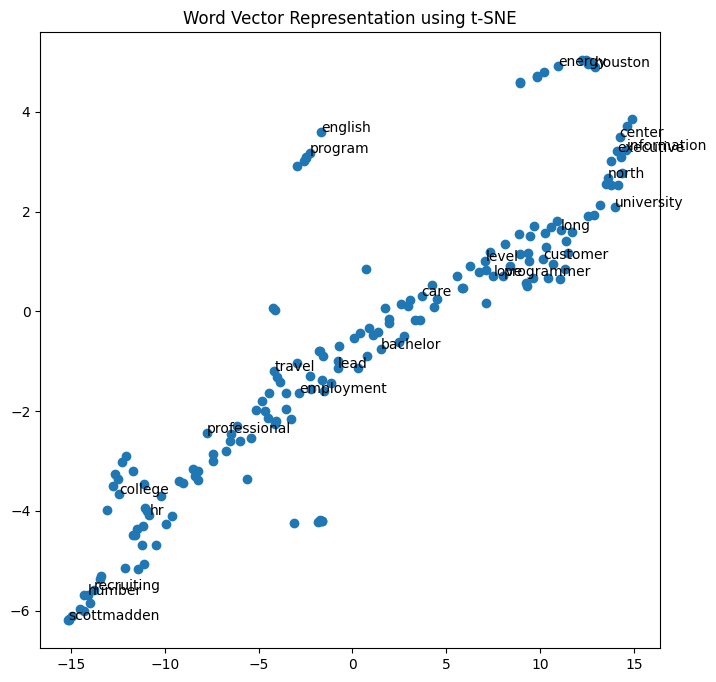

In [44]:
plot_vector_representation(model=word_2_vec_model)

The above scatterplot of words are from the 197 words that were trained on the basic Word2Vec model. 

With so few words used to train, the representation is quite uninsightful at how these 197 words are related to each other.

The two cells below show this model and the Tf-IDF model from earlier in the notebook.

In [45]:
model_recommendation(word_2_vec_model, job_title_vectors, 'apsiring human resources', end_num=20)

job_title
Human Resources Generalist at ScottMadden Inc                              70
Human Resources Professional                                               73
Human Resources Generalist at Loparex                                     100
Aspiring Human Resources Manager seeking internship in Human Resources     72
Aspiring Human Resources Specialist                                        59
Aspiring Human Resources Specialist                                        35
Aspiring Human Resources Specialist                                        23
Aspiring Human Resources Specialist                                        48
Aspiring Human Resources Specialist                                         5
Human Resources Generalist at Schwans                                      77
Aspiring Human Resources Professional                                      96
Aspiring Human Resources Professional                                       2
Aspiring Human Resources Professional                 

In [46]:
get_recomendations('aspiring human resources', top_n=10)

job_title
Aspiring Human Resources Professional    96
Aspiring Human Resources Professional    57
Aspiring Human Resources Professional    16
Aspiring Human Resources Professional    32
Aspiring Human Resources Professional    20
Aspiring Human Resources Professional    45
Aspiring Human Resources Professional     2
Aspiring Human Resources Specialist       5
Aspiring Human Resources Specialist      59
Aspiring Human Resources Specialist      35
Name: candidate_index, dtype: int64

In [47]:
## a trained Word2Vec model with a small corpus
corpus_path = datapath('lee_background.cor')
lines = [line for line in open(corpus_path)]
lines_split = [line.split(' ') for line in lines]

model = Word2Vec(lines_split, seed=SEED)
model.build_vocab(candidate_list_without_stopwords, update=True)
model.train(candidate_list_without_stopwords, total_examples=model.corpus_count, epochs=model.epochs)

print(f"The length of the vocabulary of the first Word2Vec model: {len(word_indexes)}\n")
print(f"The length of the vocabulary of the trained Word2Vec model on small corpus: {len(model.wv.key_to_index.keys())}")

The length of the vocabulary of the first Word2Vec model: 177

The length of the vocabulary of the trained Word2Vec model on small corpus: 1788


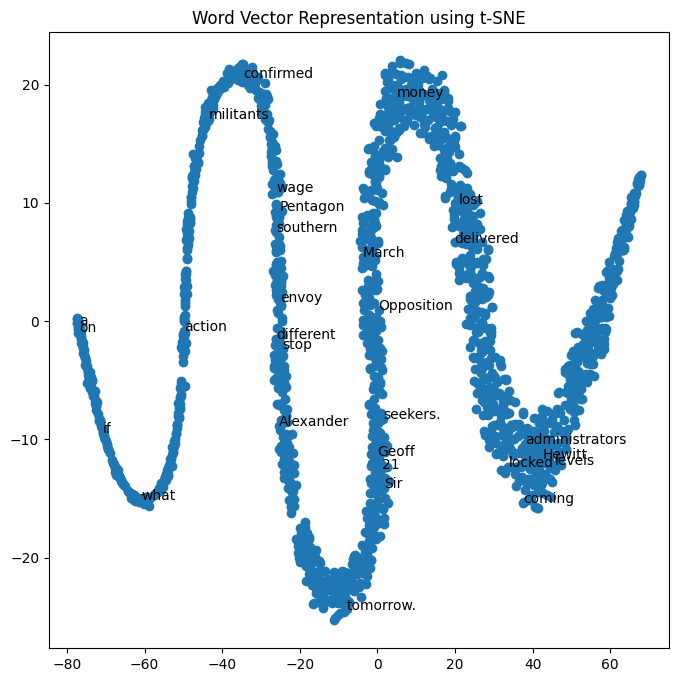

In [48]:
plot_vector_representation(model, n=30)

In [49]:
job_title_vectors_small = get_job_title_vectors(candidate_list_without_stopwords, model)

In [50]:
model_recommendation(model=model, job_title_vectors=job_title_vectors_small, phrase='aspiring human resources', end_num=20)

job_title
Liberal Arts Major Aspiring Human Resources Analyst                                                                    78
Aspiring Human Resources Professional                                                                                  32
Aspiring Human Resources Professional                                                                                  16
Aspiring Human Resources Professional                                                                                  57
Aspiring Human Resources Professional                                                                                  20
Aspiring Human Resources Professional                                                                                  45
Aspiring Human Resources Professional                                                                                   2
Aspiring Human Resources Professional                                                                                  96
Aspiring Human

Adding almost 10x more words to the model we can visualize a little better at how the model is classifying word similarities, but when looking at the recommendations we see that some of the job titles that are returned are nowhere near the phrase that was put in. 

In [51]:
## pre-trained Word2Vec models
api.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [52]:
# google300_model = api.load('word2vec-google-news-300')

# google300_model.save('../Save_Models/google-300-model.w2v')

word2vec_google300_model = gensim.models.keyedvectors.KeyedVectors.load('../Save_Models/google-300-model.w2v', mmap='r')

In [53]:
oov_words = []

for candidate in candidate_list_without_stopwords:
    for word in candidate:
        if word not in word2vec_google300_model.key_to_index.keys():
            oov_words.append(word)

print("Unique words that do not show up in pre-trained 'word2vec-google-news-300' model:")
set(oov_words) ## unique words that are from the job_title feature that are added to the word2vec model

Unique words that do not show up in pre-trained 'word2vec-google-news-300' model:


{'bayar',
 'beneteau',
 'buckhead',
 'celal',
 'chro',
 'delphi',
 'endemol',
 'engie',
 'epik',
 'gphr',
 'humber',
 'jti',
 'kokomo',
 'loparex',
 'luxottica',
 'nortia',
 'schwans',
 'scottmadden',
 'sphr',
 'styczynski',
 'westfield'}

In [54]:
google_job_title_vectors = get_job_title_vectors(candidate_list_without_stopwords, word2vec_google300_model)

In [55]:
model_recommendation(model=word2vec_google300_model, job_title_vectors=google_job_title_vectors, phrase='aspiring human resources', end_num=20)

job_title
Aspiring Human Resources Professional                                     57
Aspiring Human Resources Professional                                     96
Aspiring Human Resources Professional                                      2
Aspiring Human Resources Professional                                     20
Aspiring Human Resources Professional                                     16
Aspiring Human Resources Professional                                     32
Aspiring Human Resources Professional                                     45
Aspiring Human Resources Specialist                                       59
Aspiring Human Resources Specialist                                       48
Aspiring Human Resources Specialist                                       23
Aspiring Human Resources Specialist                                        5
Aspiring Human Resources Specialist                                       35
Aspiring Human Resources Manager seeking internship in Human Resou

In [56]:
word2vec_google300_model.most_similar('aspiring')

[('Aspiring', 0.6979072093963623),
 ('budding', 0.6776217818260193),
 ('wannabe', 0.6766116619110107),
 ('Budding', 0.5551577806472778),
 ('wannabes', 0.5387597680091858),
 ('aspire', 0.5188270807266235),
 ('aspirant', 0.5171263813972473),
 ('ASPIRING', 0.5131423473358154),
 ('exceptionally_gifted', 0.5045831203460693),
 ('young', 0.5037559270858765)]

The cell above shows the most similar words to 'apsiring' from the trained Word2Vec model

### SpaCy

In [58]:
## YOU CAN IGNORE this code block

nlp = spacy.load('en_core_web_sm')

docs = [nlp(candidate) for candidate in candidate_list_without_stopwords_]
print(docs[:1])

print([(word.text, word.pos_, word.ent_type) for word in docs[0]])

[ct bauer college business graduate magna cum laude aspiring human resources professional]
[('ct', 'PROPN', 0), ('bauer', 'PROPN', 0), ('college', 'NOUN', 0), ('business', 'PROPN', 0), ('graduate', 'PROPN', 0), ('magna', 'PROPN', 380), ('cum', 'PROPN', 380), ('laude', 'NOUN', 380), ('aspiring', 'VERB', 380), ('human', 'ADJ', 0), ('resources', 'NOUN', 0), ('professional', 'NOUN', 0)]


### GloVe

In [59]:
# glove_wv = api.load('glove-wiki-gigaword-300')

# glove_wv.save(',,/Save_Models/glove-wiki-300.wv')

glove_model = gensim.models.keyedvectors.KeyedVectors.load('../Save_Models/glove-wiki-300.wv', mmap='r')


In [60]:
len(glove_model.key_to_index.keys())

400000

In [61]:
glove_job_title_vectors = get_job_title_vectors(candidate_list_without_stopwords, glove_model)

In [62]:
model_recommendation(model=glove_model, job_title_vectors=glove_job_title_vectors, phrase='aspiring human resources', end_num=20)

job_title
Aspiring Human Resources Specialist                                       59
Aspiring Human Resources Specialist                                       35
Aspiring Human Resources Specialist                                       23
Aspiring Human Resources Specialist                                        5
Aspiring Human Resources Specialist                                       48
Aspiring Human Resources Professional                                     20
Aspiring Human Resources Professional                                     45
Aspiring Human Resources Professional                                     96
Aspiring Human Resources Professional                                     16
Aspiring Human Resources Professional                                     57
Aspiring Human Resources Professional                                     32
Aspiring Human Resources Professional                                      2
Aspiring Human Resources Manager seeking internship in Human Resou

In [63]:
glove_model.most_similar(['aspiring'])

[('budding', 0.5192381739616394),
 ('wannabe', 0.5169098973274231),
 ('filmmakers', 0.48970839381217957),
 ('entrepreneurs', 0.48700714111328125),
 ('up-and-coming', 0.4637458920478821),
 ('actors', 0.45911598205566406),
 ('singers', 0.45040252804756165),
 ('actresses', 0.43909892439842224),
 ('talented', 0.43314477801322937),
 ('musicians', 0.42924872040748596)]

Using a trained GloVe model in the same manner as Word2Vec, the recommendations are different and insightful as to what words are being calculated as similar.

### FastText

In [64]:
#### FastText model trained on small corpus (just like Word2Vec above)

fast_text_model = FastText(lines_split, seed=SEED)
fast_text_model.build_vocab(candidate_list_without_stopwords, update=True)
fast_text_model.train(candidate_list_without_stopwords, total_examples=model.corpus_count, epochs=model.epochs)

fast_text_dictionary = fast_text_model.wv.key_to_index
print(f"Length of fast_text dictionary: {len(fast_text_dictionary)}")

print(f"Length of the fast_text dictionary with stopwords removed: {len([words for words in fast_text_dictionary.keys() if words not in STOPWORDS])}")

Length of fast_text dictionary: 1788
Length of the fast_text dictionary with stopwords removed: 1579


In [65]:
print('model' in fast_text_dictionary.keys())

False


In [66]:
fast_text_model.wv['model']

array([ 0.11411129, -0.13167894,  0.0681908 , -0.04933124, -0.02346624,
       -0.15062034, -0.0247345 , -0.08406096, -0.09325299,  0.14004232,
       -0.10582874,  0.15728669, -0.18401432,  0.10116466, -0.00591985,
       -0.12603353,  0.12706836, -0.07319594,  0.0834582 , -0.03229388,
       -0.04459011,  0.07767101,  0.04925197,  0.15915196, -0.09188428,
        0.06970779,  0.02995627,  0.10298194,  0.17697604, -0.16755345,
       -0.04903474, -0.05053961, -0.12726082,  0.06484159, -0.06961478,
       -0.0680294 , -0.14275976,  0.21696539,  0.07769731, -0.27049705,
       -0.04078884, -0.0636082 , -0.21513082, -0.02684731,  0.21574818,
       -0.07851965,  0.00316601,  0.11936062,  0.05138756,  0.03550437,
        0.02091543, -0.10840025, -0.07321156,  0.02465826, -0.05242711,
       -0.03347533,  0.00921254, -0.00129416,  0.07649334, -0.02393539,
        0.14682426, -0.09964962, -0.11837273, -0.06526149,  0.06102614,
       -0.1670644 ,  0.07018254, -0.11987365, -0.00602134, -0.14

In [67]:
### testing to see what the FastText Model would output from the first word that appeared in the oov_words list
fast_text_model.wv[oov_words[0]]

array([ 1.17737763e-02, -2.04730146e-02,  1.31505616e-02, -4.41013603e-03,
       -2.72253249e-03, -2.08662916e-02, -5.01477206e-03, -1.09295584e-02,
       -1.31230652e-02,  1.88070219e-02, -1.53351901e-02,  2.37506852e-02,
       -2.99484432e-02,  1.54119572e-02,  5.41494170e-04, -1.68356430e-02,
        1.62981879e-02, -9.20193270e-03,  1.53302038e-02, -9.46874451e-03,
       -4.37782286e-03,  1.17146019e-02,  8.51950888e-03,  2.54054610e-02,
       -1.59457494e-02,  1.00938324e-02,  3.23107000e-03,  1.46179758e-02,
        2.66187545e-02, -2.49124877e-02, -5.12473471e-03, -6.32933574e-03,
       -1.97390486e-02,  1.03184776e-02, -9.23154317e-03, -9.16203018e-03,
       -2.25988403e-02,  3.00937369e-02,  9.92244110e-03, -3.47599164e-02,
       -7.72586884e-03, -9.04332940e-03, -3.28878239e-02,  4.85014607e-04,
        2.89724749e-02, -1.33150257e-02,  1.44466863e-03,  1.76981464e-02,
        9.05393716e-03,  4.94163763e-03,  5.08094300e-03, -1.38242086e-02,
       -1.34389037e-02,  

The cells above show the power of Fast_Text in that it can represent a word NOT in the dictionary of pre-trained words.

In the examples, 'model' is still represented as well as the first word in the out-of-vocab words list.

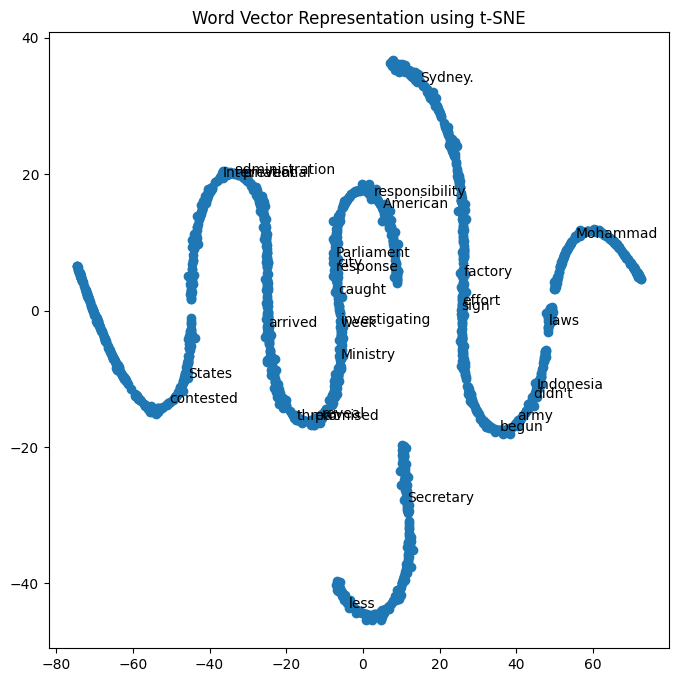

In [68]:
plot_vector_representation(model=fast_text_model, n=30)

In [69]:
fast_text_job_vectors = get_job_title_vectors(candidate_list_without_stopwords, fast_text_model)

In [70]:
model_recommendation(model=fast_text_model, job_title_vectors=fast_text_job_vectors, phrase='aspiring human resources', end_num=20)

job_title
Aspiring Human Resources Specialist                                                                            59
Aspiring Human Resources Specialist                                                                             5
Aspiring Human Resources Specialist                                                                            35
Aspiring Human Resources Specialist                                                                            48
Aspiring Human Resources Specialist                                                                            23
Aspiring Human Resources Professional                                                                          16
Aspiring Human Resources Professional                                                                           2
Aspiring Human Resources Professional                                                                          57
Aspiring Human Resources Professional                                         

In [71]:
####### pre-trained FastText model ##########


# fast_text_wiki_300 = api.load('fasttext-wiki-news-subwords-300')

# fast_text_wiki_300.save('fast-text-300.wv')

fast_text_wiki_300_model = gensim.models.keyedvectors.KeyedVectors.load('../Save_Models/fast-text-300.wv', mmap='r')

In [72]:
print(f"Length of the pre-trained fast_text_wiki_300 model: {len(fast_text_wiki_300_model.key_to_index.keys())}")

Length of the pre-trained fast_text_wiki_300 model: 999999


In [73]:
fast_text_vectors_300 = get_job_title_vectors(candidate_list_without_stopwords, fast_text_wiki_300_model)

In [74]:
model_recommendation(model=fast_text_wiki_300_model, job_title_vectors=fast_text_vectors_300, phrase='aspiring human resources', end_num=20)

job_title
Aspiring Human Resources Professional                                      57
Aspiring Human Resources Professional                                      20
Aspiring Human Resources Professional                                      96
Aspiring Human Resources Professional                                      32
Aspiring Human Resources Professional                                      16
Aspiring Human Resources Professional                                      45
Aspiring Human Resources Professional                                       2
Aspiring Human Resources Specialist                                         5
Aspiring Human Resources Specialist                                        48
Aspiring Human Resources Specialist                                        59
Aspiring Human Resources Specialist                                        23
Aspiring Human Resources Specialist                                        35
Aspiring Human Resources Manager seeking internship in

In [75]:
fast_text_wiki_300_model.most_similar('aspiring')

[('aspirant', 0.754055917263031),
 ('would-be', 0.7167032957077026),
 ('up-and-coming', 0.7014073729515076),
 ('budding', 0.6973006725311279),
 ('aspirants', 0.6967974305152893),
 ('wannabe', 0.6743366122245789),
 ('aspired', 0.6698567867279053),
 ('aspire', 0.6613301038742065),
 ('Aspiring', 0.6600536108016968),
 ('young', 0.6594008207321167)]

### GloVe

In [76]:
## pre-trained GloVe model
model_recommendation(model=glove_model, job_title_vectors=glove_job_title_vectors, phrase='aspiring human resources', end_num=20)

job_title
Aspiring Human Resources Specialist                                       59
Aspiring Human Resources Specialist                                       35
Aspiring Human Resources Specialist                                       23
Aspiring Human Resources Specialist                                        5
Aspiring Human Resources Specialist                                       48
Aspiring Human Resources Professional                                     20
Aspiring Human Resources Professional                                     45
Aspiring Human Resources Professional                                     96
Aspiring Human Resources Professional                                     16
Aspiring Human Resources Professional                                     57
Aspiring Human Resources Professional                                     32
Aspiring Human Resources Professional                                      2
Aspiring Human Resources Manager seeking internship in Human Resou

In [77]:
## base Word2Vec model
model_recommendation(model=word_2_vec_model, job_title_vectors=job_title_vectors, phrase='aspiring human resources', end_num=20)

job_title
Aspiring Human Resources Professional                                16
Aspiring Human Resources Professional                                 2
Aspiring Human Resources Professional                                45
Aspiring Human Resources Professional                                57
Aspiring Human Resources Professional                                20
Aspiring Human Resources Professional                                96
Aspiring Human Resources Professional                                32
Aspiring Human Resources Specialist                                  23
Aspiring Human Resources Specialist                                   5
Aspiring Human Resources Specialist                                  59
Aspiring Human Resources Specialist                                  48
Aspiring Human Resources Specialist                                  35
Human Resources Professional                                         73
Student at Humber College and Aspiring Human Resources

In [78]:
## Tf-IDF model
get_recomendations('aspiring human resources')

job_title
Aspiring Human Resources Professional    96
Aspiring Human Resources Professional    57
Aspiring Human Resources Professional    16
Aspiring Human Resources Professional    32
Aspiring Human Resources Professional    20
Aspiring Human Resources Professional    45
Aspiring Human Resources Professional     2
Aspiring Human Resources Specialist       5
Aspiring Human Resources Specialist      59
Aspiring Human Resources Specialist      35
Name: candidate_index, dtype: int64

### Full Sentence Embeddings

This section will be useful in the next notebook when we got to implement RankNet and LambdaRank.

Using a general sentence-similarity model as well as a BERT model from HuggingFace to tokenize the job titles in the dataset we can obtain cosine similarity scores for each job title to see how each job title relates to other job titles.

In [79]:
import transformers
from sentence_transformers import SentenceTransformer
import h5py

sentence_similarity_scores = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2') ## instantiates a SentenceTransformer similarity model

sentence_embeddings = sentence_similarity_scores.encode(candidate_list_without_stopwords_) ## for each job_title (which has been stripped, lowered, unecessary words and numbers taken out) in the dataset the model creates a 384 dimension vector space used for similarity comparison

## for saving the embeddings
# with h5py.File('../Save_Models/embeddings.h5', 'w') as f:
#     f.create_dataset('embeddings', data=sentence_embeddings)

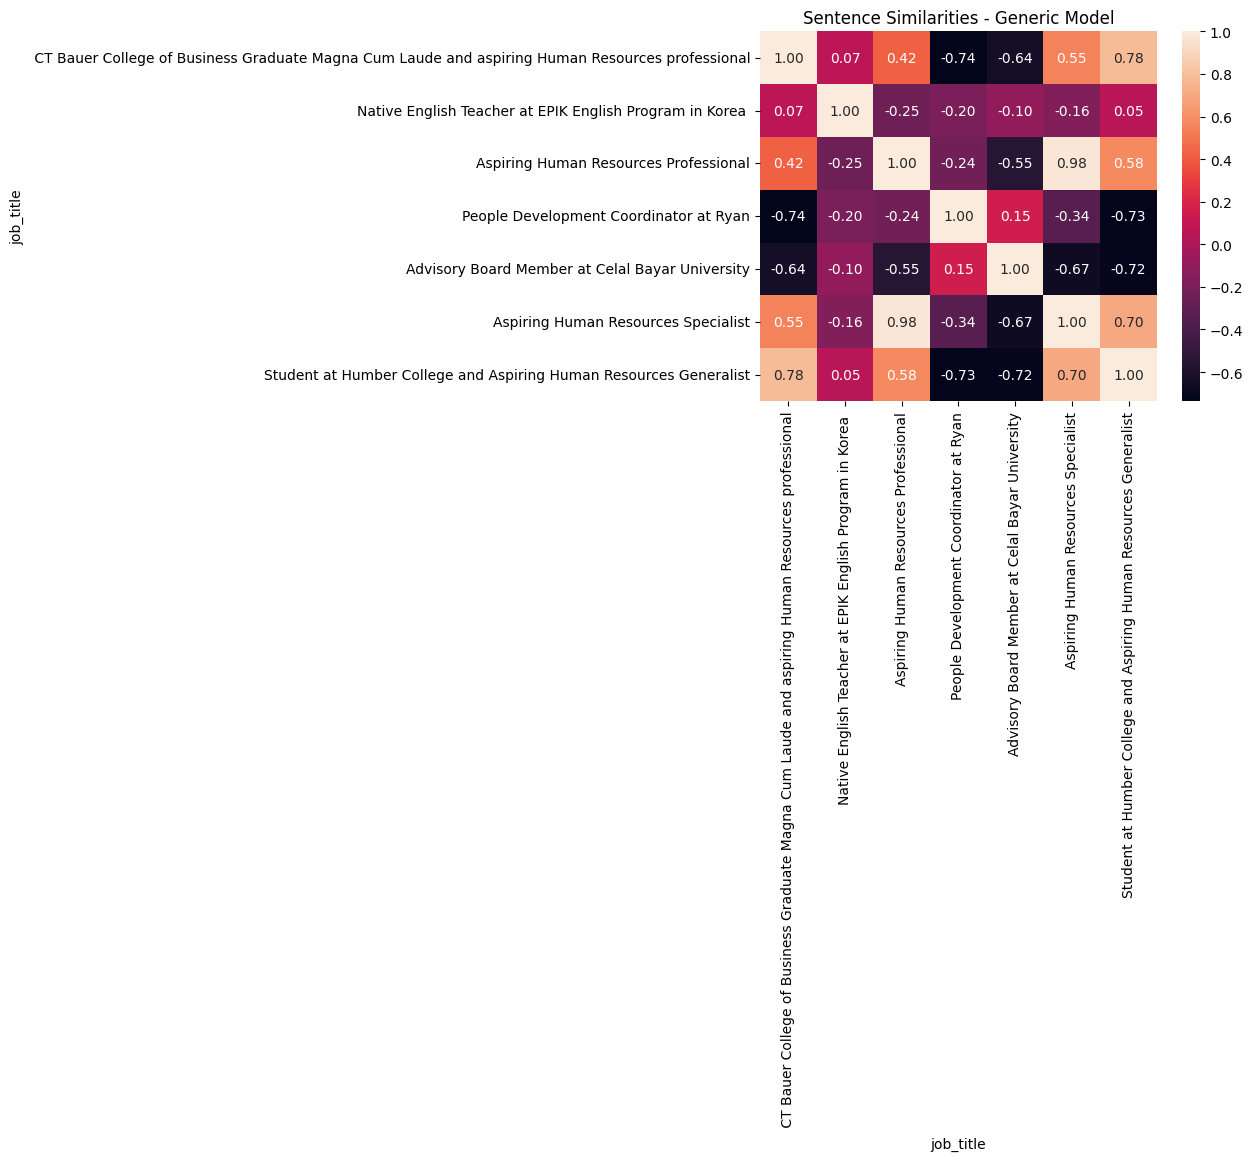

In [296]:
## for reading the embeddings back in
# with h5py.File('../Save_Models/embeddings.h5', 'r') as f:
#     sentence_embeddings = f['embeddings'][:]

sim_scores = cosine_similarity(sentence_embeddings, sentence_embeddings)

sentence_embeddings_df = pd.DataFrame(sim_scores[:7, :7], index=df['job_title'][:7], columns=df['job_title'][:7]) ## looks at similarity between the first 7 job titles

## creates a seaborn heatmap of candidates' job titles and compares them to other job titles
sns.heatmap(data=sentence_embeddings_df.corr(), annot=True, fmt='.2f')
plt.title('Sentence Similarities - Generic Model')
plt.show()

### BERT

In [ ]:
from transformers import AutoTokenizer, BertModel
import torch

tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
model = BertModel.from_pretrained('google-bert/bert-base-uncased')

inputs = tokenizer(candidate_list_without_stopwords_,
                    return_tensors='pt',
                    truncation=True,
                    padding=True
                    )
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

In [ ]:
print(last_hidden_states.shape)

## for creating the 104 candidate bert embeddings
# np_zeros = np.zeros(shape=(1, last_hidden_states.shape[2]))

# candidate_bert_embeddings = []

# for candidate in last_hidden_states.tolist():
#     for vector in candidate:
#         total_embedding = np.add(np_zeros, vector)
#     candidate_bert_embeddings.append(total_embedding.tolist()[0])

In [ ]:
## for saving the bert embeddings
# with h5py.File('../Save_Models/bert_embeddings.h5', 'w') as f:
#     f.create_dataset('bert_embeddings', data=candidate_bert_embeddings)

In [ ]:
## for laoding the bert embeddings
with h5py.File('../Save_Models/bert_embeddings.h5', 'r') as f:
    sentence_embeddings = f['bert_embeddings'][:]

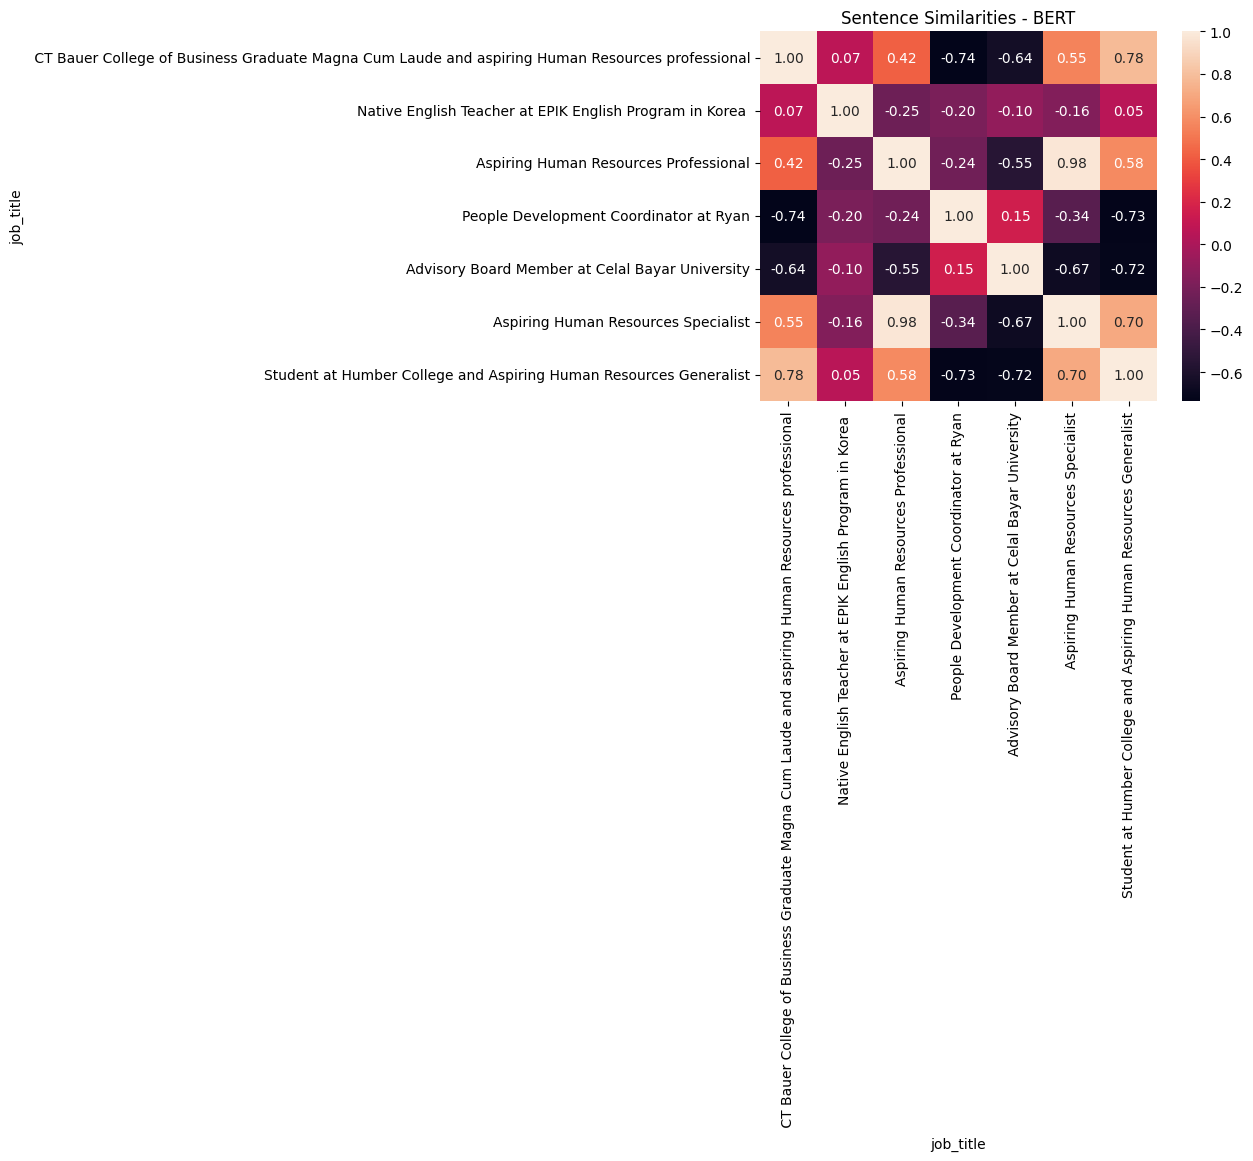

In [297]:
sim_scores = cosine_similarity(sentence_embeddings, sentence_embeddings)

bert_embeddings_df = pd.DataFrame(sim_scores[:7, :7], index=df['job_title'][:7], columns=df['job_title'][:7]) ## looks at similarity between the first 7 job titles

## creates a seaborn heatmap of candidates' job titles and compares them to other job titles
sns.heatmap(data=bert_embeddings_df.corr(), annot=True, fmt='.2f')
plt.title('Sentence Similarities - BERT')
plt.show()

In [81]:
#### for Sentence Similarities models

def sentence_sim_model_recommendations(model, phrase=str, start_num=int(0), end_num=int(10)):
    '''
    --- Parameters ---
    model: SentenceTransformer that uses a 'sentence similarity' model from HuggingFace
    phrase: job title to compare with other job titles in the dataset
    start_num: int() that indexes the beginning of a range of candidates
        Default=0. Indexes the beginning of the list of ordered candidates
    end_num: int() that indexes the end of the range of candidates
        Default=10. Indexes stops at the 10th candidate in the ordered list

    --- Returns ---
    A pandas Series of the top_n candidates and their ID
    '''
    
    phrase = phrase.strip().lower()

    phrase_embedding_vector = model.encode(phrase)

    cosine_sim = [cosine_similarity([phrase_embedding_vector], [candidate]) for candidate in sentence_embeddings]

    _df = pd.DataFrame({'cosine_scores': cosine_sim, 'candidate_id': df.index+1}, index=df['job_title'])

    sorted_df = _df.sort_values(by='cosine_scores', ascending=False)
    
    return sorted_df[start_num:end_num].candidate_id

In [82]:
sentence_sim_model_recommendations(sentence_similarity_scores, phrase='aspiring human resources', end_num=50)

job_title
Aspiring Human Resources Professional                                                                                   46
Aspiring Human Resources Professional                                                                                   17
Aspiring Human Resources Professional                                                                                    3
Aspiring Human Resources Professional                                                                                   58
Aspiring Human Resources Professional                                                                                   33
Aspiring Human Resources Professional                                                                                   97
Aspiring Human Resources Professional                                                                                   21
Aspiring Human Resources Specialist                                                                                     60
Aspiri

### Fast Text

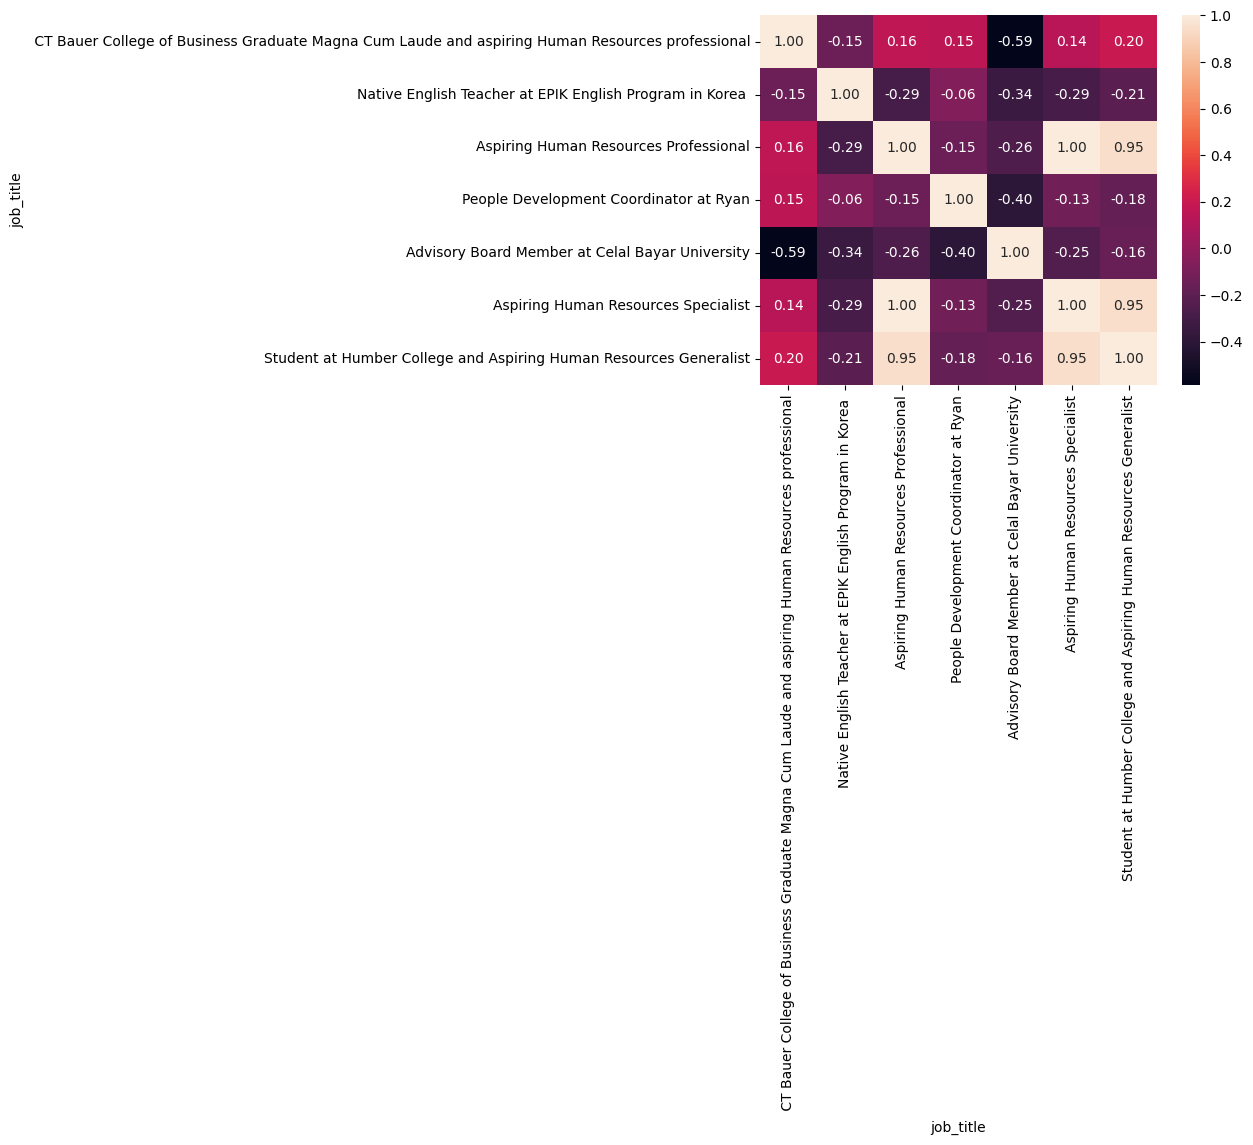

In [83]:
fast_text_cosine_scores = cosine_similarity(fast_text_vectors_300, fast_text_vectors_300)

fast_text_df = pd.DataFrame(fast_text_cosine_scores[:7, :7], index=df['job_title'][:7], columns=df['job_title'][:7])

sns.heatmap(data=fast_text_df.corr(), annot=True, fmt='.2f')
plt.show()

In [84]:
model_recommendation(model=fast_text_wiki_300_model, job_title_vectors=fast_text_vectors_300, phrase='aspiring human resources', end_num=50)

job_title
Aspiring Human Resources Professional                                                                                   57
Aspiring Human Resources Professional                                                                                   20
Aspiring Human Resources Professional                                                                                   96
Aspiring Human Resources Professional                                                                                   32
Aspiring Human Resources Professional                                                                                   16
Aspiring Human Resources Professional                                                                                   45
Aspiring Human Resources Professional                                                                                    2
Aspiring Human Resources Specialist                                                                                      5
Aspiri

The two heatmaps above using sentence similarities show a stark difference from the FastText model in the way that the models go about differentiating different job titles.

With that being said, the embeddings from the BERT model will be used in the next section for ranking.